In [53]:
import os
import re
import glob
import time

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import geopy.distance

import matplotlib.pyplot as plt
import seaborn as sns


In [54]:
# file not available locally on the GitHub repo, must be downloaded from http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/#download
data_path = 'UAH-DRIVESET-v1/'

files = glob.glob(data_path+'*/*/SEMANTIC_ONLINE*.txt', recursive=True)


In [55]:
def get_class(drive_class):
    
    drive_class = re.sub(r'[0-9]', '', drive_class)
    
    if drive_class == 'NORMAL':
        return drive_class
    else:
        return 'NOT NORMAL'
    

In [56]:
def get_info(file):
    
    drive_info = file.split('/')[2].split('-')
    
    drive_date = drive_info[0]
    dist_km = drive_info[1][:-2]
    driver = drive_info[2]
    road_type = drive_info[4]
    
    return drive_date, dist_km, driver, road_type

In [57]:
df_drive = pd.DataFrame()

for i,file in enumerate(files):
    
    drive_info = get_info(file)
    
    if i == 0:
        df_drive = pd.read_csv(file, delimiter=' ', header=None)
        df_drive.drop(list(range(11,len(df_drive.columns))), axis=1, inplace=True)
        
        df_drive[['date_time', 'total_dist', 'driver_id', 'road_type']] = drive_info
        
        df_drive['delta_time_s'] = df_drive[0].diff()
        df_drive['delta_lat'] = df_drive[1].diff()
        df_drive['delta_lon'] = df_drive[2].diff()
        
    else:
        temp = pd.read_csv(file, delimiter=' ', header=None)
        temp.drop(list(range(11,len(temp.columns))), axis=1, inplace=True)
        
        temp[['date_time', 'total_dist', 'driver_id', 'road_type']] = drive_info
        
        temp['delta_time_s'] = temp[0].diff()
        temp['delta_lat'] = temp[1].diff()
        temp['delta_lon'] = temp[2].diff()
        
        df_drive = df_drive.append(temp, ignore_index=True)

df_drive = df_drive.dropna().reset_index(drop=True)      
        

In [58]:
df_drive.columns = ['time_s', 'lat', 'lon',
                    'total_score',
                    'acceleration_score', 'braking_score', 'turning_score', 'weaving_score',
                    'drifting_score', 'speeding_score', 'follow_score',
                    'date_time_raw', 'total_dist', 'driver_id', 'road_type',
                    'delta_time_s', 'delta_lat', 'delta_lon']

df_drive['date_time_clean'] = pd.to_datetime(df_drive['date_time_raw']).dt.round('30min')
df_drive['date_time_clean'] = pd.to_datetime(df_drive['date_time_clean']).dt.strftime('%Y-%m-%d %I:%M %p')


In [59]:
df_weather = pd.read_csv('UAH-DRIVESET-weather.csv', index_col=0)


In [60]:
df = pd.merge(df_drive.astype(str), df_weather.astype(str), on=['driver_id', 'date_time_raw', 'road_type', 'total_dist'])
df = df.apply(pd.to_numeric, errors='ignore')


In [61]:
df['speed_mph'] = [geopy.distance.distance((lat, df['lon'][i]), (lat+df['delta_lat'][i], df['lon'][i]+df['delta_lon'][i])).miles / df['delta_time_s'][i] * 60.0 * 60.0 for i,lat in enumerate(df['lat'])]
df['speed_mph'] = np.where(df['speed_mph'] > 175, np.mean(df['speed_mph']), df['speed_mph']).tolist()


In [64]:
df['class_normal'] = df['class_normal'].replace('NOT NORMAL', 'ABNORMAL')
df['class_normal_bool'] = pd.get_dummies(df['class_normal'], drop_first=True)


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30751 entries, 0 to 30750
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time_s              30751 non-null  float64
 1   lat                 30751 non-null  float64
 2   lon                 30751 non-null  float64
 3   total_score         30751 non-null  float64
 4   acceleration_score  30751 non-null  float64
 5   braking_score       30751 non-null  float64
 6   turning_score       30751 non-null  float64
 7   weaving_score       30751 non-null  float64
 8   drifting_score      30751 non-null  float64
 9   speeding_score      30751 non-null  float64
 10  follow_score        30751 non-null  float64
 11  date_time_raw       30751 non-null  int64  
 12  total_dist          30751 non-null  int64  
 13  driver_id           30751 non-null  object 
 14  road_type           30751 non-null  object 
 15  delta_time_s        30751 non-null  float64
 16  delt

In [66]:
df.head()

,time_s,lat,lon,total_score,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,date_time_raw,total_dist,driver_id,road_type,delta_time_s,delta_lat,delta_lon,date_time_clean_x,class_normal,date_time_clean_y,temp_F,dp_F,humidity_pct,wind_direction,wind_speed_mph,wind_gust_mph,pressure_in,precipitation_in,condition,day_night,speed_mph,class_normal_bool
0,8.8,40.512924,-3.404577,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,20151110175712,16,D1,SECONDARY,1.0,0.000137,-0.000100,2015-11-10 06:00 PM,NORMAL,2015-11-10 06:00 PM,72,43,35,VAR,2,0,28.32,0.0,Fair,Night,38.955226,1
1,9.8,40.513065,-3.404680,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,20151110175712,16,D1,SECONDARY,1.0,0.000141,-0.000103,2015-11-10 06:00 PM,NORMAL,2015-11-10 06:00 PM,72,43,35,VAR,2,0,28.32,0.0,Fair,Night,40.099995,1
2,10.8,40.513210,-3.404772,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,20151110175712,16,D1,SECONDARY,1.0,0.000145,-0.000092,2015-11-10 06:00 PM,NORMAL,2015-11-10 06:00 PM,72,43,35,VAR,2,0,28.32,0.0,Fair,Night,40.018755,1
3,11.8,40.513348,-3.404868,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,20151110175712,16,D1,SECONDARY,1.0,0.000138,-0.000096,2015-11-10 06:00 PM,NORMAL,2015-11-10 06:00 PM,72,43,35,VAR,2,0,28.32,0.0,Fair,Night,38.811020,1
4,12.8,40.513477,-3.404971,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,20151110175712,16,D1,SECONDARY,1.0,0.000129,-0.000103,2015-11-10 06:00 PM,NORMAL,2015-11-10 06:00 PM,72,43,35,VAR,2,0,28.32,0.0,Fair,Night,37.524521,1


In [67]:
df.describe()

,time_s,lat,lon,total_score,acceleration_score,braking_score,turning_score,weaving_score,drifting_score,speeding_score,follow_score,date_time_raw,total_dist,delta_time_s,delta_lat,delta_lon,temp_F,dp_F,humidity_pct,wind_speed_mph,wind_gust_mph,pressure_in,precipitation_in,speed_mph,class_normal_bool
count,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,3.075100e+04,30751.000000,30751.000000,30751.000000,30751.000000,30751.000000,30751.00000,30751.000000,30751.000000,30751.000000,30751.000000,30751.0,30751.000000,30751.000000
mean,420.512627,40.512073,-3.449896,80.965871,93.894999,81.388101,75.630080,79.410097,67.499928,82.195711,87.756863,2.015116e+13,21.077493,1.003493,-0.000001,0.000001,58.958928,40.50678,52.270040,3.005171,0.765764,28.344112,0.0,58.704492,0.422783
std,251.161918,0.039105,0.050733,12.625995,11.623922,30.511233,31.015459,35.393026,19.600651,25.054338,23.596517,4.605877e+07,4.694991,0.194971,0.000128,0.000280,6.668351,6.49727,13.456821,3.052421,4.649888,0.108545,0.0,13.624506,0.494010
min,8.600000,40.463497,-3.557913,46.600000,0.000000,0.000000,0.000000,0.000000,13.600000,0.000000,0.000000,2.015111e+13,12.000000,0.400000,-0.001209,-0.005798,41.000000,25.00000,25.000000,0.000000,0.000000,28.150000,0.0,0.000000,0.000000
25%,210.150000,40.471291,-3.483300,71.800000,92.500000,77.400000,63.200000,60.000000,50.000000,77.100000,91.400000,2.015112e+13,16.000000,1.000000,-0.000099,-0.000269,57.000000,37.00000,45.000000,1.000000,0.000000,28.290000,0.0,52.506410,0.000000
50%,402.600000,40.504444,-3.450341,82.200000,100.000000,99.700000,87.500000,100.000000,71.000000,93.200000,98.800000,2.015113e+13,25.000000,1.000000,0.000000,0.000000,59.000000,41.00000,49.000000,2.000000,0.000000,28.370000,0.0,57.199916,0.000000
75%,604.900000,40.548822,-3.410203,92.600000,100.000000,100.000000,100.000000,100.000000,84.500000,98.400000,100.000000,2.015121e+13,25.000000,1.000000,0.000095,0.000265,61.000000,45.00000,59.000000,5.000000,0.000000,28.400000,0.0,64.646376,1.000000
max,1118.300000,40.584969,-3.353321,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2.015122e+13,26.000000,18.000000,0.001655,0.008524,72.000000,50.00000,87.000000,17.000000,29.000000,28.510000,0.0,155.833533,1.000000


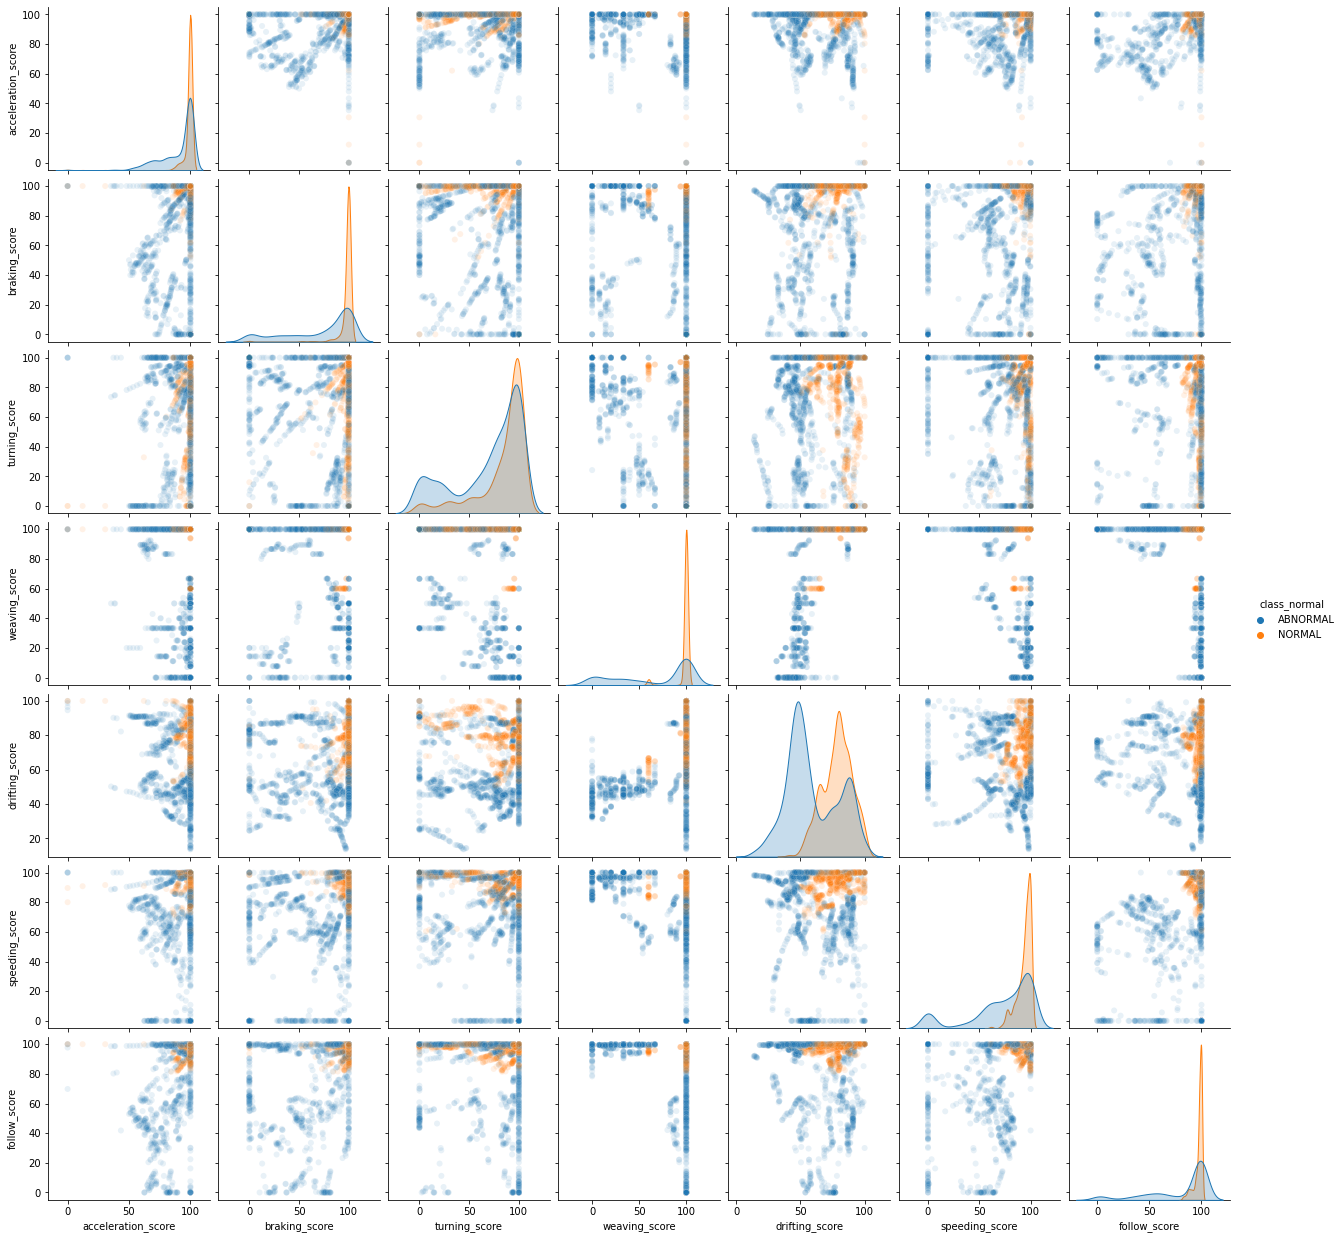

In [68]:
cols = ['acceleration_score',
        'braking_score', 'turning_score', 'weaving_score', 'drifting_score',
        'speeding_score', 'follow_score',
        'driver_id', 'road_type', 'class_normal']

sns.pairplot(df.sample(2500, random_state=42)[cols], hue='class_normal', plot_kws={'alpha': 0.1})


<AxesSubplot:xlabel='drifting_score', ylabel='Count'>

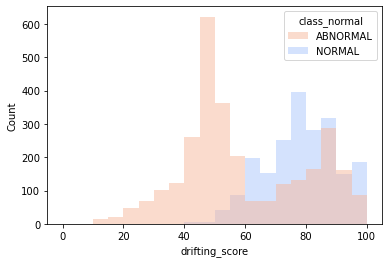

In [103]:
sns.histplot(data=df.sample(5000, random_state=42), x='drifting_score', hue='class_normal',
            fill=True, common_norm=False, palette='coolwarm_r',
            alpha=0.5, linewidth=0, bins=np.arange(0,105,5))


<AxesSubplot:xlabel='speeding_score', ylabel='Count'>

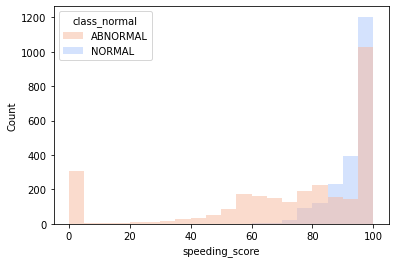

In [104]:
sns.histplot(data=df.sample(5000, random_state=42), x='speeding_score', hue='class_normal',
            fill=True, common_norm=False, palette='coolwarm_r',
            alpha=0.5, linewidth=0, bins=np.arange(0,105,5))


ABNORMAL    0.577217
NORMAL      0.422783
Name: class_normal, dtype: float64

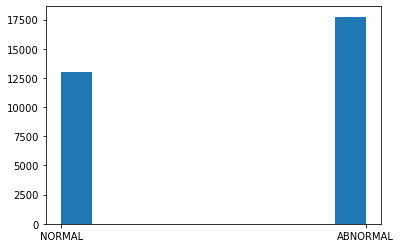

In [105]:
plt.hist(df['class_normal'])
df['class_normal'].value_counts(normalize=True)


In [21]:
df_save = df.drop(['time_s', 'lat', 'lon', 'total_score', 'date_time_raw', 'total_dist', 'driver_id',
                   'delta_time_s', 'delta_lat', 'delta_lon',
                   'date_time_clean_x', 'date_time_clean_y', 'dp_F', 'wind_direction', 'pressure_in', 'precipitation_in'], axis=1)


<AxesSubplot:>

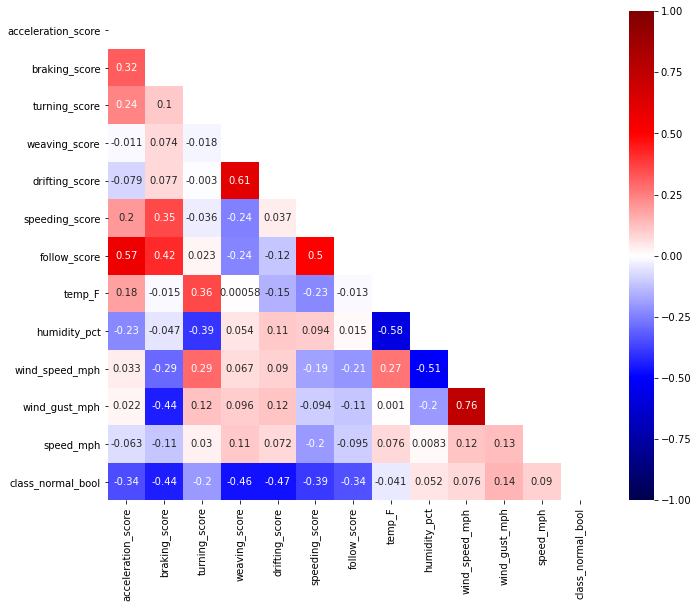

In [22]:
fig, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(df_save.corr(), dtype=bool))
sns.heatmap(df_save.corr(), mask=mask, cmap='seismic', vmin=-1.0, vmax=1.0, annot=True)

In [23]:
df_save.to_csv('UAH-DRIVESET-classification.csv')
